# Interpreting recurrent neural networks with LIME

This is the second part of my blog post on the LIME interpretation model. For a reminder of what LIME is and its purpose, please read the [first part](https://nkthiebaut.github.io/lime-of-words.html). This second part is a quick application of the same algorithm to a deep learning (LSTM) model, while the first part was focused on explaining the predictions of a random forest. 

As a reminder we use movie reviews from [IMDB](www.imdb.com) to predict the sentiment of the review (positive if the author of the comment gave 7 stars and above, negative elsewise).

In [1]:
import pandas as pd
df = pd.read_csv('../content/labeledTrainData.tsv', sep='\t')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [2]:
from sklearn.model_selection import train_test_split

texts_train, texts_test, y_train, y_test = \
    train_test_split(df["review"].values, df['sentiment'].values, random_state=42)

## Modelling with LSTM

In this example of LIME usage I use a Long Short-Term Memory (LSTM) network to predict the sentiment (positive or negative) associated with an IMDB movie review. LSTM is a specific kind of recurrent neural network that is well explained rather informally [here](http://www.wildml.com/2015/10/recurrent-neural-network-tutorial-part-4-implementing-a-grulstm-rnn-with-python-and-theano/), and more in a more detailed way [there](http://colah.github.io/posts/2015-08-Understanding-LSTMs/).

### Preprocessing
In order to preprocess text in a convenient way that can be easily handled by the LIME library, I build a scikit-learn [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) object that handles a list of texts as input and returns the prediction of a neural network, thanks to the [Keras](https://keras.io) scikit-learn API.

Pipelines combine various Transformer objects to transform data from raw input to a predicted output. In our case we have to define 2 custom Transformers to translate input text in a form that can be handled by our LSTM. The first transformer takes a list of texts as input and outputs a list of indices lists, for instance ```[["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]].```

The second transformer harmonizes input lengths to a given *maxlen*, padding with zeros if the sequence is too short, and cropping the beginning of the sequence if it is too long. 

After application of those 2 Transformers we end up with a matrix of shape *(n_samples, maxlen)*, readily usable by Keras models. 

In [3]:
vocab_size = 20000  # Max number of different word, i.e. model input dimension
maxlen = 80  # Max number of words kept at the end of each text

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator

class TextsToSequences(Tokenizer, BaseEstimator, TransformerMixin):
    """ Sklearn transformer to convert texts to indices list 
    (e.g. [["the cute cat"], ["the dog"]] -> [[1, 2, 3], [1, 4]])"""
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        
    def fit(self, texts, y=None):
        self.fit_on_texts(texts)
        return self
    
    def transform(self, texts, y=None):
        return np.array(self.texts_to_sequences(texts))
        
sequencer = TextsToSequences(num_words=vocab_size)

Using TensorFlow backend.


In [5]:
class Padder(BaseEstimator, TransformerMixin):
    """ Pad and crop uneven lists to the same length. 
    Only the end of lists longernthan the maxlen attribute are
    kept, and lists shorter than maxlen are left-padded with zeros
    
    Attributes
    ----------
    maxlen: int
        sizes of sequences after padding
    max_index: int
        maximum index known by the Padder, if a higher index is met during 
        transform it is transformed to a 0
    """
    def __init__(self, maxlen=500):
        self.maxlen = maxlen
        self.max_index = None
        
    def fit(self, X, y=None):
        self.max_index = pad_sequences(X, maxlen=self.maxlen).max()
        return self
    
    def transform(self, X, y=None):
        X = pad_sequences(X, maxlen=self.maxlen)
        X[X > self.max_index] = 0
        return X

padder = Padder(maxlen)

### LSTM construction and training

We now simply have to chain our preprocessing Transformers and our LSTM model. Here I have chosen a rather standard network with 128 hidden units, and dropout rate of 50 %. I only train during 2 epochs as I don't monitor overffiting here, but a more performant model could be trained with more epochs and early stopping. 

Note that we use a [Bidirectional LSTM](https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks) here, that uses information from both preceeding and following words to compute a word representation when scanning a sentence, but this is a detail for our purpose.

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

batch_size = 64
max_features = vocab_size + 1

def create_model(max_features):
    """ Model creation function: returns a compiled Bidirectional LSTM"""
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])
    return model

# Use Keras Scikit-learn wrapper to instantiate a LSTM with all methods
# required by Scikit-learn for the last step of a Pipeline
sklearn_lstm = KerasClassifier(build_fn=create_model, epochs=2, batch_size=batch_size, 
                               max_features=max_features, verbose=1)

# Build the Scikit-learn pipeline
pipeline = make_pipeline(sequencer, padder, sklearn_lstm)

pipeline.fit(texts_train, y_train);

Epoch 1/2
18750/18750 [==============================] - 259s - loss: 0.5450 - acc: 0.7294      

In [19]:
from sklearn import metrics
print('Computing predictions on test set...')
y_preds = pipeline.predict(texts_test)

print('Test accuracy: {:.2f} %'.format(100*metrics.accuracy_score(y_preds, y_test)))

Computing predictions on test set...
6250/6250 [==============================] - 24s     

 Performances are similar to the *TF-IDF + Random forest* model of the first part of this post (82% accuracy). Hence we do not have enough data to leverage the modelling power of our LSTM, but this example is enough to illustrate the usage of LIME for a deep learning model. As before we choose an example and compute feature importance with the LIME package. 

In [45]:
# We choose a sample from test set
idx = 11
text_sample = texts_test[idx]
class_names = ['negative', 'positive']

print('Sample {}: last 80 words (only part used by the model)'.format(idx))
print('-'*50)
print(" ".join(text_sample.split()[-80:]))
print('-'*50)
print('Probability(positive) =', pipeline.predict_proba([text_sample])[0,1])
print('True class: %s' % class_names[y_test[idx]])

Sample 11: last 80 words (only part used by the model)
--------------------------------------------------
Who? What? Where? When? Why? The acting was terrible. Very robotic, rehearsed. I have seen all of the actors in this film in better roles. The screenplay was very elementary. By the end of this film, the story line was tied up. And Jeane Claude LaMarre should be tied up, too. So that he never attempts to write/direct another film.
--------------------------------------------------
1/1 [==============================] - 0s
Probability(positive) = 0.112901
True class: negative


5000/5000 [==============================] - 20s      128/5000 [..............................] - ETA: 19s

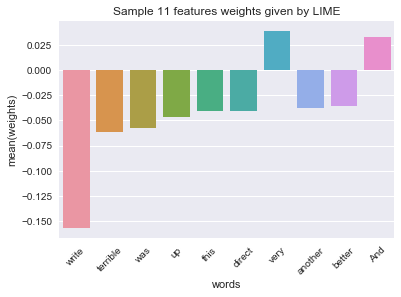

In [46]:
import seaborn as sns
%matplotlib inline
from collections import OrderedDict
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=class_names)
explanation = explainer.explain_instance(text_sample, pipeline.predict_proba, num_features=10)

weights = OrderedDict(explanation.as_list())
lime_weights = pd.DataFrame({'words': list(weights.keys()), 'weights': list(weights.values())})

sns.barplot(x="words", y="weights", data=lime_weights);
plt.xticks(rotation=45)
plt.title('Sample {} features weights given by LIME'.format(idx));

As for the first model, we get an ensemble of 10 explanation features that seem make sense. Note the fact that "write" has a large negative weight, probably because it is preceeded by "he never attempts to" in our example (and the LSTM model is aware of the ordering of words!).

## Conclusion

We have used the LIME interpretation to provide explanations for the individual predictions of a random forest model working on TF-IDF features, and a recurrent neural network. In both cases LIME outputs important features that make sense. 

While we were having a way to obtain weights for single predictions with the random forest, LIME could also provide a sign that allows for a deeper understanding of the model output. In the case of the reccurent neural network, LIME is even more important as it is harder than for the random forest to extract the relevant weights to determine the most important features. 

According to my experiments, LIME appears as an interesting method to interpret a model output. Its model agnostic aspect helps to compare different models within the same framework, and may become an important tool to assess models relevance, in addition to the standard performance metrics that are sensitive to datasets (ubiquitous :) leaks from the future, or can be misleading when evaluation metrics definition is tricky. 